# Value of Plays Using Run Expectancy

## 5.1 The Run Expectancy Matrix

The **run expectancy matrix** is a fundamental sabermetrics concept that calculates the average number of runs expected to score for each game state (combination of baserunners and outs).

**Key concepts:**
- 8 possible base states (each of 3 bases can be empty or occupied: 2³ = 8)
- 3 possible out states (0, 1, or 2 outs)
- **24 total game states** (8 × 3 = 24)

##  5.2 Runs Scored in the Remainder of the Inning

$$\text{runs}_{\text{roi}} = \text{runs}_{\text{Total in Inning}} - \text{runs}_{\text{So far in Inning}}$$

This calculates how many runs will be scored from the current game state until the end of the inning.

### Data Source

Using Retrosheet play-by-play data for the 2016 MLB season. Each row represents a single plate appearance with detailed information about the game state, players involved, and the outcome of the play.

In [49]:
import pandas as pd
fields = pd.read_csv('../data/fields.csv')
headers = fields['Header'].str.lower().tolist()

retro2016 = pd.read_csv('../data/all2016.csv', names=headers, low_memory=False)

In [50]:
retro2016['runs_before'] = retro2016['away_score_ct'] + retro2016['home_score_ct']

retro2016['half_inning'] = retro2016[['game_id', 'inn_ct', 'bat_home_id']].astype(str).agg(' '.join, axis=1)

In [51]:
retro2016['runs_scored'] = (
    (retro2016['bat_dest_id'] > 3).astype(int) + 
    (retro2016['run1_dest_id'] > 3).astype(int) + 
    (retro2016['run2_dest_id'] > 3).astype(int) + 
    (retro2016['run3_dest_id'] > 3).astype(int)
)

In [52]:
half_innings = retro2016.groupby('half_inning').agg({
    'event_outs_ct': 'sum',
    'runs_scored': 'sum',
    'runs_before': 'first'
}).reset_index()

half_innings.columns = ['half_inning', 'outs_inning', 'runs_inning', 'runs_start']

half_innings['max_runs'] = half_innings['runs_inning'] + half_innings['runs_start']

In [53]:
retro2016 = retro2016.merge(half_innings, on='half_inning', how='inner')

retro2016['runs_roi'] = retro2016['max_runs'] - retro2016['runs_before']

## 5.3 Creating the Matrix

Now that runs scored in the remainder of each inning (`runs_roi`) have been calculated, the run expectancy matrix can be built out.

**Creating the game state variable:**
- Combine baserunner positions into a 3-digit code
- Add the number of outs to create complete game states
- Examples:
  - "011 2" = runners on 2nd and 3rd with 2 outs
  - "100 0" = runner on 1st with 0 outs

In [54]:
import numpy as np

retro2016['bases'] = (
    np.where(retro2016['base1_run_id'].notna() & (retro2016['base1_run_id'] != ''), '1', '0') +
    np.where(retro2016['base2_run_id'].notna() & (retro2016['base2_run_id'] != ''), '1', '0') +
    np.where(retro2016['base3_run_id'].notna() & (retro2016['base3_run_id'] != ''), '1', '0')
)

retro2016['state'] = retro2016['bases'] + ' ' + retro2016['outs_ct'].astype(str)

In [55]:
retro2016['is_runner1'] = (
    (retro2016['run1_dest_id'] == 1) | (retro2016['bat_dest_id'] == 1)
).astype(int)

retro2016['is_runner2'] = (
    (retro2016['run1_dest_id'] == 2) | 
    (retro2016['run2_dest_id'] == 2) | 
    (retro2016['bat_dest_id'] == 2)
).astype(int)

retro2016['is_runner3'] = (
    (retro2016['run1_dest_id'] == 3) | 
    (retro2016['run2_dest_id'] == 3) |
    (retro2016['run3_dest_id'] == 3) | 
    (retro2016['bat_dest_id'] == 3)
).astype(int)

retro2016['new_outs'] = retro2016['outs_ct'] + retro2016['event_outs_ct']

retro2016['new_bases'] = (
    retro2016['is_runner1'].astype(str) +
    retro2016['is_runner2'].astype(str) +
    retro2016['is_runner3'].astype(str)
)

retro2016['new_state'] = retro2016['new_bases'] + ' ' + retro2016['new_outs'].astype(str)

In [56]:
changes2016 = retro2016[(retro2016['state'] != retro2016['new_state']) | 
                        (retro2016['runs_scored'] > 0)].copy()

changes2016_complete = changes2016[changes2016['outs_inning'] == 3].copy()

In [57]:
erm_2016 = changes2016_complete.groupby(['bases', 'outs_ct']).agg(
    mean_run_value=('runs_roi', 'mean')
).reset_index()

erm_2016.pivot(
    index='bases', 
    columns='outs_ct', 
    values='mean_run_value'
).rename(columns=lambda x: f'Outs={x}')

erm_2016.to_pickle('../data/erm_2016.pkl')

### Comparing Run Expectancy Across Eras

To see how run expectancy values have changed over time, comparing the 2016 season values with 2002 season values.

In [58]:
erm_2002 = pd.DataFrame({
    'OLD=0': [0.51, 1.40, 1.14, 1.96, 0.90, 1.84, 1.51, 2.33],
    'OLD=1': [0.27, 0.94, 0.68, 1.36, 0.54, 1.18, 0.94, 1.51],
    'OLD=2': [0.10, 0.36, 0.32, 0.63, 0.23, 0.52, 0.45, 0.78]
}, index=['000', '001', '010', '011', '100', '101', '110', '111'])

out = erm_2016.pivot(
    index='bases',
    columns='outs_ct',
    values='mean_run_value'
).rename(columns=lambda x: f'NEW={x}')

out = pd.concat([out, erm_2002], axis=1)

out

,NEW=0,NEW=1,NEW=2,OLD=0,OLD=1,OLD=2
000,0.498168,0.267903,0.106208,0.51,0.27,0.10
001,1.346979,0.936888,0.371953,1.40,0.94,0.36
010,1.133176,0.672856,0.312491,1.14,0.68,0.32
011,1.928788,1.357786,0.548168,1.96,1.36,0.63
100,0.857981,0.512134,0.220206,0.90,0.54,0.23
101,1.723270,1.195757,0.478245,1.84,1.18,0.52
110,1.444663,0.920621,0.413610,1.51,0.94,0.45
111,2.106105,1.537215,0.695272,2.33,1.51,0.78


### Stability Over Time

These run expectancy values have remained very stable over recent baseball history. This indicates there have been few changes in the average run scoring tendencies of MLB teams between 2002 and 2016.


## 5.4 Measuring Success of a Batting Play

### Calculating Run Value

The run value of a play measures its impact by comparing run expectancy before and after the play.

$$\text{RUN VALUE} = \text{RUNS}_{\text{New state}} - \text{RUNS}_{\text{Old state}} + \text{RUNS}_{\text{Scored on Play}}$$

In [59]:
retro2016 = (retro2016
    .merge(erm_2016[['bases', 'outs_ct', 'mean_run_value']], 
           on=['bases', 'outs_ct'], how='left')
    .rename(columns={'mean_run_value': 'rv_start'})
    .merge(erm_2016.rename(columns={'bases': 'new_bases', 'outs_ct': 'new_outs'})[
        ['new_bases', 'new_outs', 'mean_run_value']], 
           on=['new_bases', 'new_outs'], how='left')
    .rename(columns={'mean_run_value': 'rv_end'})
    .fillna({'rv_end': 0}) 
)

retro2016['run_value'] = retro2016['rv_end'] - retro2016['rv_start'] + retro2016['runs_scored']

## 5.5 José Altuve

Looking at 2016 plate appearances to understand run values.

In [60]:
people = pd.read_csv('../data/lahman/People.csv')
altuve_id = people[
    (people['nameFirst'] == 'Jose') & (people['nameLast'] == 'Altuve')
]['retroID'].iloc[0]

print(altuve_id)

altuj001


In [61]:
altuve = retro2016[(retro2016['bat_id'] == altuve_id) & (retro2016['bat_event_fl'] == 'T')]

How did Altuve do in his first three plate appearances this season?

In [62]:
altuve[['state', 'new_state', 'run_value']].head(3)

,state,new_state,run_value
1772,000 1,000 2,-0.161695
1798,000 1,100 1,0.244231
1818,000 1,000 2,-0.161695


- First AB: no runners on base with one out. Resulting AB was an out
- Second AB: bases were empty with one out. Resulting AB was on base with positive `run_value`
- Third AB: bases empty with one out.  Resulting AB was another out

In [63]:
altuve.groupby('bases').size().reset_index(name='N')

,bases,N
0,000,417
1,001,24
2,010,60
3,011,18
4,100,128
5,101,22
6,110,40
7,111,8


Most of the time Altuve was batting with bases empty or a runner only on first

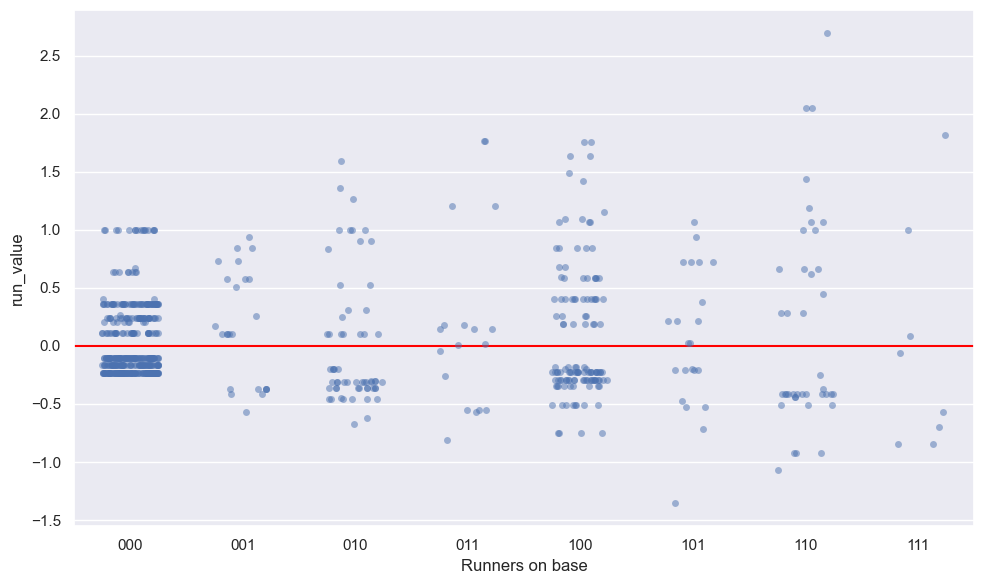

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))

base_order = ['000', '001', '010', '011', '100', '101', '110', '111']

sns.stripplot(data=altuve, x='bases', y='run_value', alpha=0.5, jitter=0.25, ax=ax, order=base_order)

ax.axhline(y=0, color='red')

ax.set_xlabel('Runners on base')
ax.set_ylabel('run_value')

plt.tight_layout()
plt.show()

Plot shows the run values for all Altuve's plate appearances by runners state

### Altuve's 2016 total run production

In [65]:
runs_altuve = altuve.groupby('bases').agg(
    PA=('bases', 'size'),
    total_run_values=('run_value', 'sum')
).reset_index()

runs_altuve

,bases,PA,total_run_values
0,000,417,10.098301
1,001,24,4.060483
2,010,60,0.069487
3,011,18,3.433512
4,100,128,10.193986
5,101,22,1.341679
6,110,40,5.623835
7,111,8,-0.096793


Altuve did not appear to do particularly well with runners in scoring position in 2016.
- 60 PAs with a runner on second base and had a net contribution of 0.7 runs

In [66]:
float(runs_altuve['total_run_values'].sum())

34.72449009958008

## 5.6 Opportunity and Success for All Hitters

In [67]:
retro2016_bat = retro2016[retro2016['bat_event_fl'] == 'T']

In [68]:
run_exp = retro2016_bat.groupby('bat_id').agg(
    RE24=('run_value', 'sum'),
    PA=('run_value', 'size'),
    runs_start=('rv_start', 'sum')
).reset_index()

In [69]:
run_exp_400 = run_exp[run_exp['PA'] >= 400]
run_exp_400.head(6)

,bat_id,RE24,PA,runs_start
1,abrej003,13.584615,695,336.315363
15,alony001,-5.275563,532,249.240831
17,altuj001,34.724490,717,346.261303
24,andet001,-11.494229,431,205.069635
27,andre001,17.725131,568,256.657091
29,aokin001,-1.909316,467,229.044228


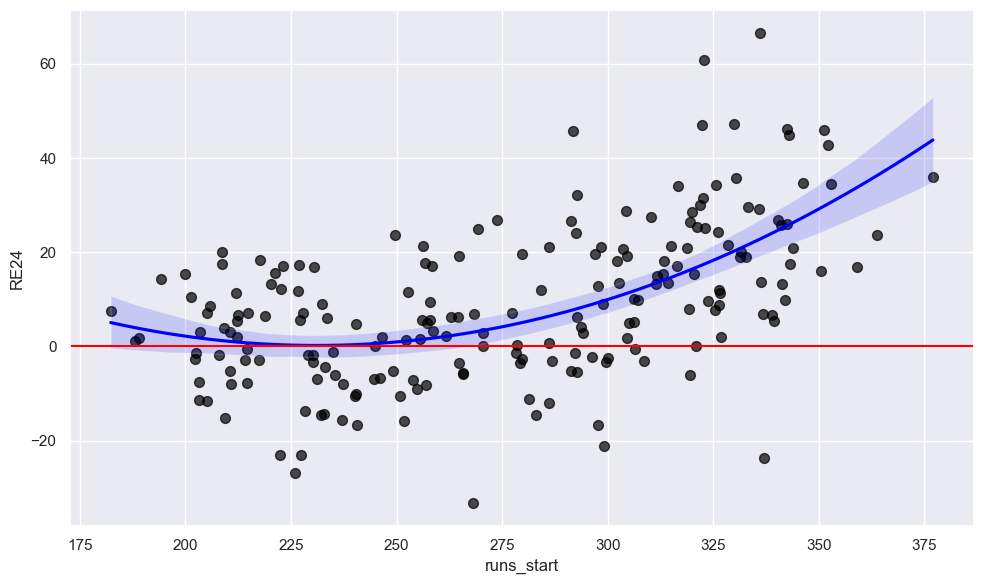

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.regplot(data=run_exp_400, x='runs_start', y='RE24', 
            order=2,
            scatter_kws={'color': 'black', 's': 50, 'alpha': 0.7},
            line_kws={'color': 'blue'},
            ax=ax)

ax.axhline(y=0, color='red')

ax.set_xlabel('runs_start')
ax.set_ylabel('RE24')

plt.tight_layout()
plt.show()


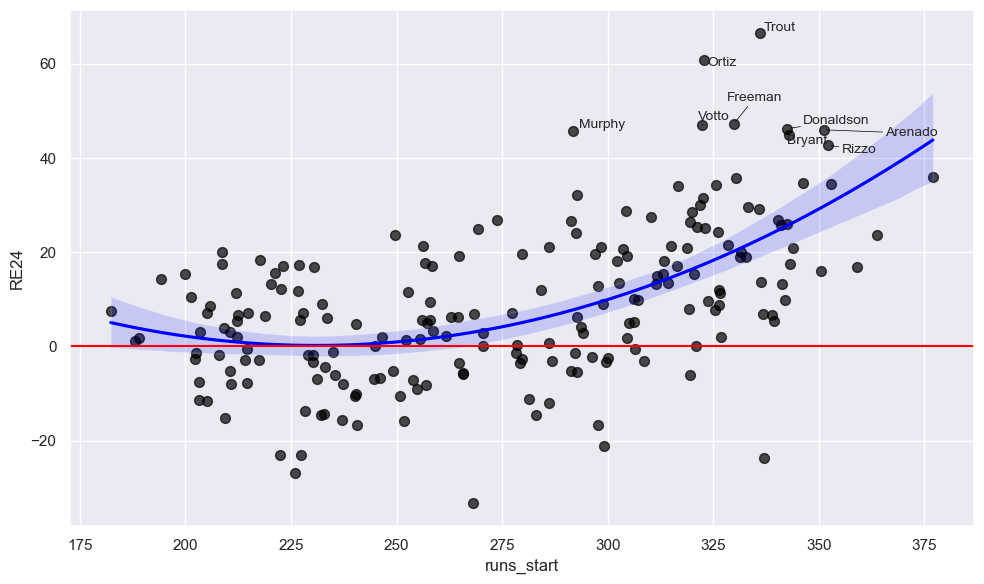

In [71]:
from adjustText import adjust_text

run_exp_400 = run_exp_400.merge(
    people[['retroID', 'nameLast']], 
    left_on='bat_id', 
    right_on='retroID', 
    how='inner'
)

fig, ax = plt.subplots(figsize=(10, 6))

sns.regplot(data=run_exp_400, x='runs_start', y='RE24', 
            order=2,
            scatter_kws={'color': 'black', 's': 50, 'alpha': 0.7},
            line_kws={'color': 'blue'},
            ax=ax)

ax.axhline(y=0, color='red')

top_players = run_exp_400[run_exp_400['RE24'] >= 40]
texts = []
for idx, row in top_players.iterrows():
    texts.append(ax.text(row['runs_start'], row['RE24'], row['nameLast'], 
                         fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

ax.set_xlabel('runs_start')
ax.set_ylabel('RE24')

plt.tight_layout()
plt.show()

- Based on the scatterplot, batters with larger values of runs_start tend to have larger runs contributions.
- Only a limited number of players created more than 40 runs for their teams (labeled in second plot).

## 5.7 Position in the Batting Lineup

Are the best hitters using the run value criterion hitting in the middle of the lineup?

In [72]:
regulars = retro2016.merge(run_exp_400, on='bat_id')

In [73]:
positions = (regulars
    .groupby(['bat_id', 'bat_lineup_id'])
    .size()
    .reset_index(name='N')
    .sort_values('N', ascending=False)
    .drop_duplicates('bat_id', keep='first')
    .rename(columns={'bat_lineup_id': 'position'})
)

run_exp_400 = run_exp_400.merge(positions[['bat_id', 'position']], on='bat_id')

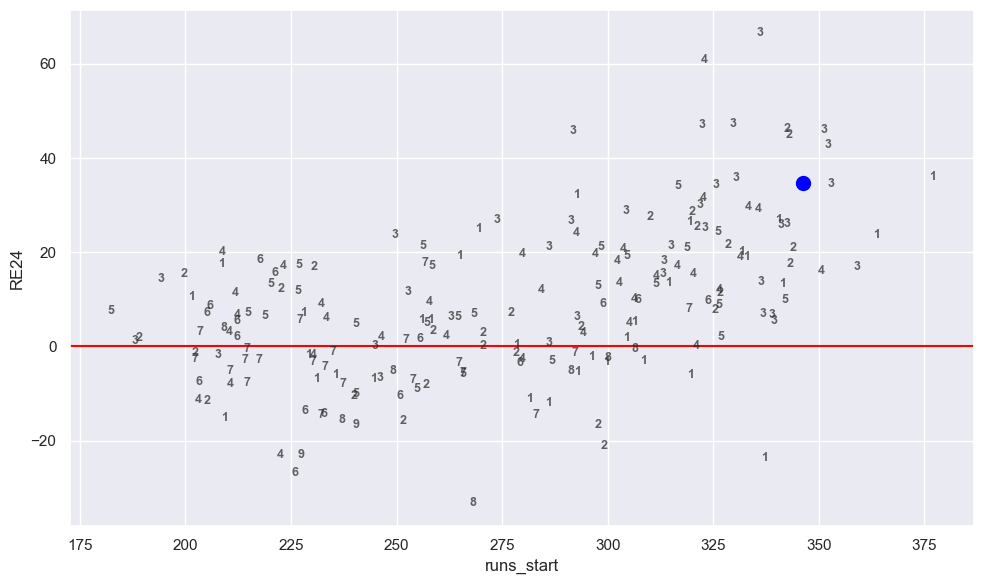

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=run_exp_400, x='runs_start', y='RE24', 
                hue='position', style='position', 
                s=0, legend=False, ax=ax)

for position in run_exp_400['position'].unique():
    subset = run_exp_400[run_exp_400['position'] == position]
    ax.scatter(subset['runs_start'], subset['RE24'], alpha=0)
    for _, row in subset.iterrows():
        ax.text(row['runs_start'], row['RE24'], str(int(row['position'])), 
                fontsize=9, ha='center', va='center', alpha=0.7, weight='bold')
        
altuve_row = run_exp_400[run_exp_400['bat_id'] == altuve_id]
if not altuve_row.empty:
    ax.scatter(altuve_row['runs_start'], altuve_row['RE24'], 
               color='blue', s=100, zorder=5)

ax.axhline(y=0, color='red')

ax.set_xlabel('runs_start')
ax.set_ylabel('RE24')

plt.tight_layout()
plt.show()

- The best hitters (the ones who create a large number of runs) generally bat third, fourth, and fifth in the batting order.
- Altuve’s (runs_start, RE24) is plotted by a large solid dot. In 2016 Altuve was one of the better hitters in terms of creating runs.

## 5.8 Run Values of Different Base Hits

Analyzing the value of a home run and a single from the perspective of creating runs.

### 5.8.1 Value of a home run

In [75]:
home_runs = retro2016[retro2016['event_cd'] == 23]

In [76]:
home_runs['state'].value_counts()

state
000 0    1530
000 1     957
000 2     845
100 1     357
100 2     340
100 0     319
010 2     158
110 2     156
010 1     150
110 1     131
010 0      98
110 0      82
101 1      74
101 2      63
001 2      61
111 2      48
111 1      44
001 1      39
011 2      39
011 1      37
101 0      28
011 0      24
111 0      18
001 0      12
Name: count, dtype: int64

In [77]:
home_runs['state'].value_counts(normalize=True).round(3)

state
000 0    0.273
000 1    0.171
000 2    0.151
100 1    0.064
100 2    0.061
100 0    0.057
010 2    0.028
110 2    0.028
010 1    0.027
110 1    0.023
010 0    0.017
110 0    0.015
101 1    0.013
101 2    0.011
001 2    0.011
111 2    0.009
111 1    0.008
001 1    0.007
011 2    0.007
011 1    0.007
101 0    0.005
011 0    0.004
111 0    0.003
001 0    0.002
Name: proportion, dtype: float64

The fraction of home runs hit with the bases empty is <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mn>0.273</mn>
  <mo>+</mo>
  <mn>0.171</mn>
  <mo>+</mo>
  <mn>0.151</mn>
  <mo>=</mo>
  <mn>0.595</mn>
</math>. So over half of the home runs are hit with no runners on base.

What is the overall run value of hitting a home run?

In [78]:
mean_hr = home_runs['run_value'].mean()
mean_hr

np.float64(1.3816001785082235)

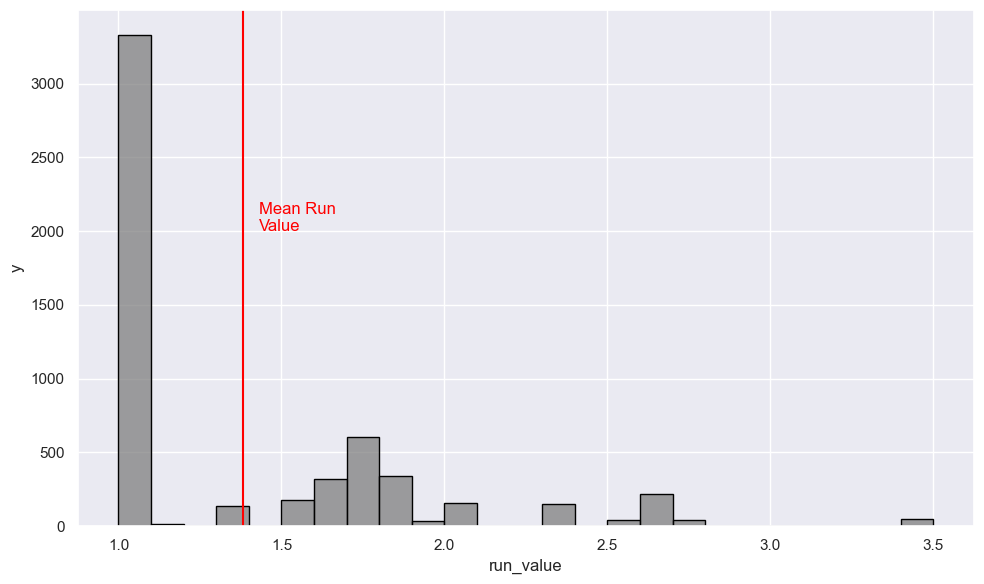

In [79]:
bins = np.arange(home_runs['run_value'].min(), 
                 home_runs['run_value'].max() + 0.1, 0.1)

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=home_runs, x='run_value', bins=bins, 
             color='gray', edgecolor='black', ax=ax)

ax.axvline(mean_hr, color='red')

ax.text(mean_hr + 0.05, 2000, 'Mean Run\nValue', color='red')

ax.set_xlabel('run_value')
ax.set_ylabel('y')

plt.tight_layout()
plt.show()

Most home runs (bases empty) have a run value of one, with some between 1.5-2.0 and a few exceeding three.

Which runner/out situations lead to the most valuable home runs? 

In [80]:
(home_runs
    .sort_values(by='run_value', ascending=False)
    [['state', 'new_state', 'run_value']]
    .head(1)
)

,state,new_state,run_value
162233,111 2,000 2,3.410936


The results above show the most valuable home run occurs when there are bases loaded with two outs.

### 5.8.2 Value of a single

In [81]:
singles = retro2016[retro2016['event_cd'] == 20]

In [82]:
mean_singles = singles['run_value'].mean()
mean_singles

np.float64(0.4394855152673472)

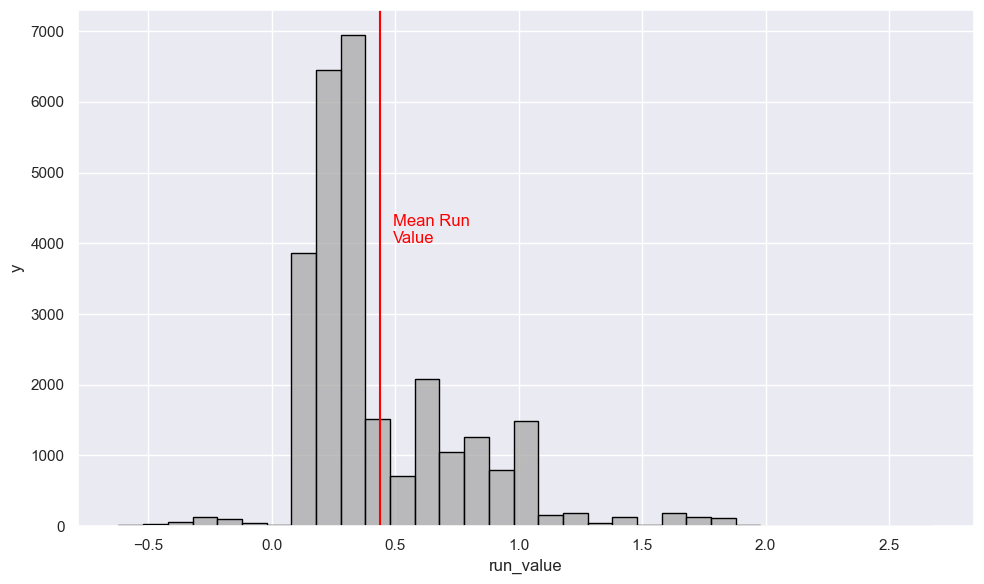

In [83]:
bins = np.arange(singles['run_value'].min(), 
                 singles['run_value'].max() + 0.1, 0.1)

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=singles, x='run_value', bins=bins, ax=ax, 
             color='darkgray', edgecolor='black')

ax.axvline(x=mean_singles, color='red')

ax.text(mean_singles + 0.05, 4000, 'Mean Run\nValue', color='red')

ax.set_xlabel('run_value')
ax.set_ylabel('y')

plt.tight_layout()
plt.show()

- Most singles occur with bases empty (the three histogram spikes correspond to 2 outs, 1 out, and 0 outs), while the cluster between 0.5-2.0 represents singles with runners on base.

In [84]:
singles['state'].value_counts()

state
000 0    6920
000 1    4767
000 2    3763
100 1    1974
100 2    1765
100 0    1665
010 2     864
010 1     745
110 2     729
110 1     697
010 0     516
101 2     368
110 0     364
001 2     354
001 1     323
101 1     321
111 1     280
111 2     257
011 1     224
011 2     208
101 0     159
111 0     115
011 0      90
001 0      71
Name: count, dtype: int64

In [85]:
(
    singles.sort_values(by='run_value', ascending=False)
    [['state', 'new_state', 'run_value']]
    .head(1)
)

,state,new_state,run_value
22050,111 2,001 2,2.676681


- The most valuable single occurred with bases loaded and 2 outs, where a fielding error allowed all three runners to score and the batter to reach third. 

In [86]:
(
    singles.sort_values(by='run_value')
    [['state', 'new_state', 'run_value']]
    .head(1)
)

,state,new_state,run_value
61765,010 0,100 1,-0.621042


- The least valuable singles occurred when a runner on second was hit by the ball and called out. 

### 5.9 Value of Base Stealing

In [87]:
stealing = retro2016[retro2016['event_cd'].isin([4, 6])]

In [88]:
result = (stealing
    .groupby('event_cd')
    .size()
    .reset_index(name='N')
)
result['pct'] = result['N'] / result['N'].sum()
result

,event_cd,N,pct
0,4,2213,0.756323
1,6,713,0.243677


The proportion of stolen bases is equal to 2213 / (2213 + 713) = 0.756.

What are common runners/outs situations for attempting a stolen base?

In [89]:
stealing.groupby('state').size().reset_index(name='N')

,state,N
0,001 1,1
1,001 2,1
2,010 0,37
3,010 1,124
4,010 2,102
5,011 1,1
6,100 0,559
7,100 1,708
8,100 2,870
9,101 0,37


- Most frequent stolen base attempts happen with a runner only on first (state 100).
- Wide variety of stolen base situations as expected 

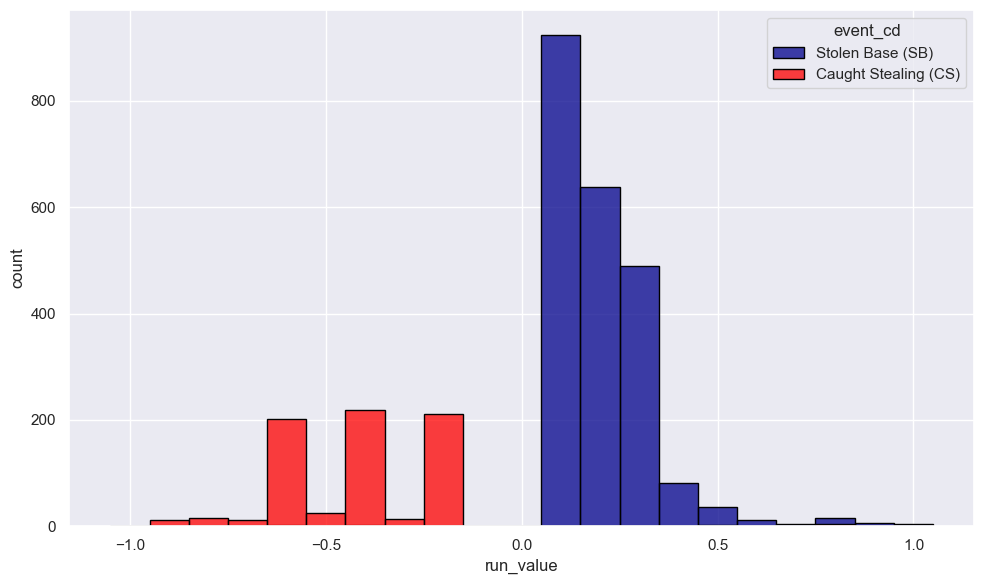

In [90]:
bins = np.arange(stealing['run_value'].min(), 
                 stealing['run_value'].max() + 0.1, 0.1)

fig, ax = plt.subplots(figsize=(10, 6))

stealing_sb = stealing[stealing['event_cd'] == 4]
stealing_cs = stealing[stealing['event_cd'] == 6]

sns.histplot(data=stealing_sb, x='run_value', bins=bins, 
             color='darkblue', edgecolor='black', ax=ax, label='Stolen Base (SB)')
sns.histplot(data=stealing_cs, x='run_value', bins=bins, 
             color='red', edgecolor='black', ax=ax, label='Caught Stealing (CS)')

ax.legend(title='event_cd', loc='upper right')

ax.set_xlabel('run_value')
ax.set_ylabel('count')

plt.tight_layout()
plt.show()

Successful stolen bases have positive run values (mostly 0-0.3), while caught stealing attempts have negative values, with three spikes corresponding to a runner on first with 0, 1, and 2 outs.

In [91]:
stealing_1001 = stealing[stealing['state'] == "100 1"]

In [92]:
result = (stealing_1001
    .groupby('event_cd')
    .size()
    .reset_index(name='N')
)
result['pct'] = result['N'] / result['N'].sum()
result

,event_cd,N,pct
0,4,498,0.70339
1,6,210,0.29661


Success rate for stolen base attempts with a runner on first and one out

In [93]:
result = (stealing_1001
    .groupby('new_state')
    .size()
    .reset_index(name='N')
)
result['pct'] = result['N'] / result['N'].sum()
result

,new_state,N,pct
0,000 1,1,0.001412
1,000 2,211,0.298023
2,001 1,39,0.055085
3,010 1,457,0.645480


For the specific case of a runner on first with one out, 457 attempts resulted in advancing to second, while 39 reached third (likely due to errors on the throw to second). 

In [94]:
stealing_1001['run_value'].mean()

np.float64(0.0072327233560250965)